In [1]:
# 基本的なライブラリ
import itertools
from tqdm import tqdm
import warnings
import numpy as np
import pandas as pd

# 描画ライブラリ
import matplotlib.pyplot as plt

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter

# config python file
import config
import functions

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
functions.fix_seed(SEED)

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)

/breast_cancer_analytics/notebooks/functions.py:412: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/breast_cancer_analytics/notebooks/functions.py:414: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# Draw KM line

In [13]:
def plot_KM(target_gene: str, subgroup, is_save: bool = False):
    ax = None
    plt.figure(figsize=(8, 6))
    plt.rcParams["font.size"] = 18
    kmf = KaplanMeierFitter()
    for val, group in df_tmp.groupby("target_gene_bin"):
        if val == 1:
            label = "gene expression value is over mean"
        elif val == -1:
            label = "gene expression value is under mean"

        kmf.fit(
            durations=group["RFS_MONTHS"],
            event_observed=group["RFS_STATUS"],
            label=label,
        )
        ax = (
            kmf.plot(show_censors=True, ax=ax)
            if ax
            else kmf.plot(show_censors=True, ax=ax)
        )

    functions.make_dir(config.FIGURES_LIFELINES_RECURRENCE_DIR)

    plt.title("lifeline analysis: ".format(target_gene))
    ax.axvline(60, color="navy")
    ax.set_xlim([0, int(5 * 12 * 3)])
    ax.set_ylim([0, 1])
    plt.tight_layout()
    plt.savefig(
        "{0}/{1}/kmf_{2}.png".format(
            config.FIGURES_LIFELINES_RECURRENCE_DIR, subgroup, target_gene
        )
    ) if is_save else plt.show()

## データ読み込み

In [3]:
patient_columns = ["RFS_MONTHS", "RFS_STATUS", "CLAUDIN_SUBTYPE"]
subgroup = "LumA"

gene_columns = pd.read_pickle(
    "./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote/train_val/X_{0}.pkl".format(
        subgroup
    )
).columns.to_list()
analytsis_columns = patient_columns + gene_columns

df_patient = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")[
    patient_columns
]
df_patient["RFS_STATUS"] = df_patient["RFS_STATUS"].replace(
    {"1:Recurred": 1, "0:Not Recurred": 0}
)
df_gene_expressions = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)
df_merged = pd.merge(df_patient, df_gene_expressions, left_index=True, right_index=True)


# manual
df_lifeline_analysis = df_merged[df_merged["CLAUDIN_SUBTYPE"] == subgroup][
    analytsis_columns
].dropna()
df_tmp = df_lifeline_analysis.drop("CLAUDIN_SUBTYPE", axis=1).copy()

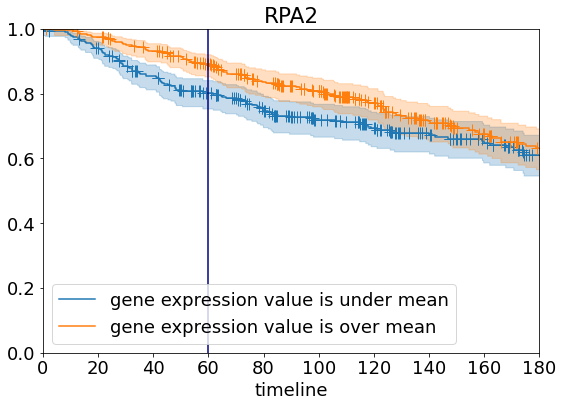

In [4]:
df_genes_threshold = df_tmp[gene_columns].apply("mean")

analysis_targets = ["RPA2"]
for gene_column in gene_columns:
    if gene_column in analysis_targets:
        df_tmp["target_gene_bin"] = df_tmp[gene_column].apply(
            lambda x: 1 if x >= df_genes_threshold[gene_column] else -1
        )
        plot_KM(gene_column, subgroup, True)

Iteration 1: norm_delta = 0.16609, step_size = 0.9500, log_lik = -1310.42006, newton_decrement = 2.83357, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00569, step_size = 0.9500, log_lik = -1307.61849, newton_decrement = 0.00344, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00028, step_size = 0.9500, log_lik = -1307.61507, newton_decrement = 0.00001, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1307.61506, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 673 total observations, 453 right-censored observations>
             duration col = 'RFS_MONTHS'
                event col = 'RFS_STATUS'
      baseline estimation = breslow
   number of observations = 673
number of events observed = 220
   partial log-likelihood = -1307.62
         time fit was run = 2022-10-20 05:31:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RPA2       -0.47       0.62       0.20            -0.87            -0.08                 0.42                 0.92

            cmp to     z    p   -log2(p)
covariate                               
RPA2          0.00 -2.38 0.02       5.87
---
Concordance = 0.57
Partial AIC = 2617.23
log-likelihood ratio test = 5.61 on 1 df
-log2(p) of ll-ratio test = 5.81

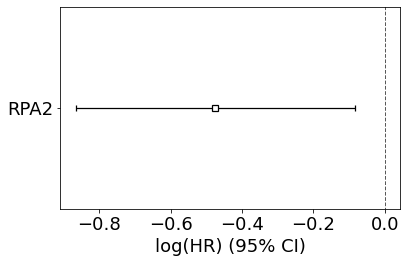

In [5]:
patient_columns = ["RFS_MONTHS", "RFS_STATUS"]


cph = CoxPHFitter()
cph.fit(
    df_tmp[analysis_targets + patient_columns],
    duration_col="RFS_MONTHS",
    event_col="RFS_STATUS",
    show_progress=True,
)
plt.rcParams["font.size"] = 18
cph.print_summary()
cph.plot()
plt.tight_layout()
functions.make_dir("{0}/LumA".format(config.FIGURES_LIFELINES_RECURRENCE_DIR))
plt.savefig("{0}/LumA/cph.png".format(config.FIGURES_LIFELINES_RECURRENCE_DIR))

# Landmark model

In [6]:
patient_columns = ["RFS_MONTHS", "RFS_STATUS", "CLAUDIN_SUBTYPE"]
subgroup = "LumA"

gene_columns = pd.read_pickle(
    "./../data/interim/PREPROCESSED/RECURRENCE/CROSS/CLAUDIN_SUBTYPE/mrmr_std_smote/train_val/X_{0}.pkl".format(
        subgroup
    )
).columns.to_list()
analytsis_columns = patient_columns + gene_columns

df_patient = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")[
    patient_columns
]
df_patient["RFS_STATUS"] = df_patient["RFS_STATUS"].replace(
    {"1:Recurred": 1, "0:Not Recurred": 0}
)
df_gene_expressions = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)
df_merged = pd.merge(df_patient, df_gene_expressions, left_index=True, right_index=True)

# manual
df_lifeline_analysis = df_merged[df_merged["CLAUDIN_SUBTYPE"] == subgroup][
    analytsis_columns
].dropna()
df_tmp = df_lifeline_analysis.drop("CLAUDIN_SUBTYPE", axis=1).copy()
df_tmp = df_tmp[df_tmp["RFS_MONTHS"] > 5 * 12]

In [11]:
def plot_KM(target_gene: str, subgroup, is_save: bool = False):
    ax = None
    plt.figure(figsize=(8, 6))
    plt.rcParams["font.size"] = 18
    kmf = KaplanMeierFitter()
    for val, group in df_tmp.groupby("target_gene_bin"):
        if val == 1:
            label = "gene expression is over medium"
        elif val == -1:
            label = "gene expression is under medium"

        kmf.fit(
            durations=group["RFS_MONTHS"],
            event_observed=group["RFS_STATUS"],
            label=label,
        )
        ax = (
            kmf.plot(show_censors=True, ax=ax)
            if ax
            else kmf.plot(show_censors=True, ax=ax)
        )
    functions.make_dir(config.FIGURES_LIFELINES_RECURRENCE_DIR)

    plt.title("landmark analysis: {0}".format(target_gene))
    # ax.axvline(60, color="navy")
    ax.set_xlim([5 * 12, 5 * 12 * 5])
    ax.set_ylim([0, 1])
    plt.tight_layout()
    plt.savefig(
        "{0}/{1}/kmf_landmark_{2}.png".format(
            config.FIGURES_LIFELINES_RECURRENCE_DIR, subgroup, target_gene
        )
    ) if is_save else plt.show()

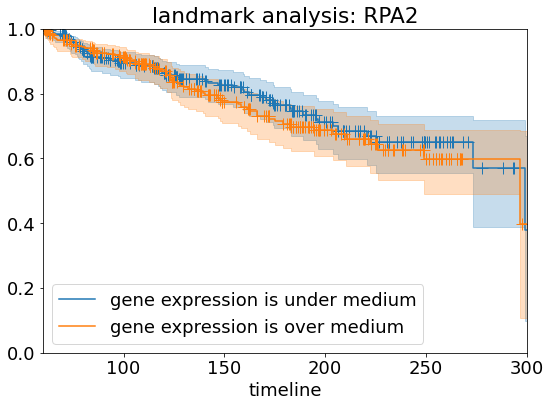

In [12]:
df_genes_threshold = df_tmp[gene_columns].apply("median")

analysis_targets = ["RPA2"]
for gene_column in gene_columns:
    if gene_column in analysis_targets:
        df_tmp["target_gene_bin"] = df_tmp[gene_column].apply(
            lambda x: 1 if x >= df_genes_threshold[gene_column] else -1
        )
        plot_KM(gene_column, subgroup, True)

Iteration 1: norm_delta = 0.07671, step_size = 0.9500, log_lik = -663.70322, newton_decrement = 0.33375, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.00433, step_size = 0.9500, log_lik = -663.36905, newton_decrement = 0.00105, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00022, step_size = 0.9500, log_lik = -663.36800, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, log_lik = -663.36800, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 4 iterations.


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 514 total observations, 395 right-censored observations>
             duration col = 'RFS_MONTHS'
                event col = 'RFS_STATUS'
      baseline estimation = breslow
   number of observations = 514
number of events observed = 119
   partial log-likelihood = -663.37
         time fit was run = 2022-10-20 05:31:19 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
RPA2        0.23       1.26       0.28            -0.32             0.78                 0.72                 2.19

            cmp to    z    p   -log2(p)
covariate                              
RPA2          0.00 0.82 0.41       1.27
---
Concordance = 0.51
Partial AIC = 1328.74
log-likelihood ratio test = 0.67 on 1 df
-log2(p) of ll-ratio test = 1.28

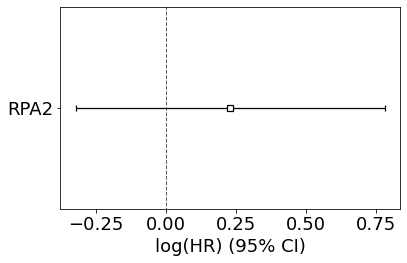

In [10]:
patient_columns = ["RFS_MONTHS", "RFS_STATUS"]

cph = CoxPHFitter()
cph.fit(
    df_tmp[analysis_targets + patient_columns],
    duration_col="RFS_MONTHS",
    event_col="RFS_STATUS",
    show_progress=True,
)
plt.rcParams["font.size"] = 18
cph.print_summary()
cph.plot()
plt.tight_layout()
# functions.make_dir("{0}/LumA".format(config.FIGURES_LIFELINES_RECURRENCE_DIR))
# plt.savefig("{0}/LumA/cph.png".format(config.FIGURES_LIFELINES_RECURRENCE_DIR))

In [ ]:
sns.histplot(
    x="STAT5B", data=df_cross, hue="OS_15years", palette={0: "blue", 1: "Orange"}
)